FACTOR INVESTING FOR VENTURE CAPITALISTS

`y_n` means "became a unicorn".

Author: [@sparshsah](https://github.com/sparshsah)

In [1]:
from typing import Final, Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.decomposition
import sklearn.linear_model
import sklearn.metrics

# https://github.com/sparshsah/foggy-statslib/blob/main/foggy_statslib/core.py
import foggy_statslib.core as fsc

# SAMPLE PCA

In [12]:
def _get_pc_mults(
    X: pd.DataFrame,
    var_frac: float | None =  0.80,
) -> pd.DataFrame:
    """Get principal-component multipliers."""
    fitter = sklearn.decomposition.PCA(
        n_components=var_frac,
    )
    fitted = fitter.fit(X)
    mults = pd.DataFrame(
        fitted.components_,
        index=[
            f"pc{i}"
            for i in range(
                1,
                fitted.components_.shape[0] + 1,
            )
        ],
        columns=X.columns,
    )
    return mults


def _calc_pc(
    X: pd.DataFrame,
    mult: pd.Series,
) -> pd.Series:
    if not X.columns.equals(
        mult.index
    ):
        raise ValueError(
            "Misaligned index"
            + f": {list(X.columns)}"
            + f", {list(mult.index)}!"
        )
    X_multed = X * mult
    pc = X_multed.sum(axis="columns")
    assert X.index.equals(
        pc.index
    )
    return pc


def calc_pcs(
    X: pd.DataFrame,
    mults: pd.DataFrame,
) -> pd.DataFrame:
    """Get principal components."""
    pcs = pd.DataFrame(
        {
            i: _calc_pc(
                X=X,
                mult=mult,
            )
            for (i, mult)
            in mults.iterrows()
        }
    )
    assert X.index.equals(
        pcs.index
    )
    return pcs


def get_rankstdized(
    X: pd.DataFrame,
    cohort: pd.Series,
    pc_mults: pd.DataFrame,
) -> pd.DataFrame:
    X = calc_pcs(
        X=X,
        mults=pc_mults,
    )
    gb = X.groupby(cohort)
    # rank
    X = gb.rank()
    gb = X.groupby(cohort)
    # stdize
    suber = gb.mean()
    diver = gb.std()
    X = (
        X
        .sub(
            suber,
            level=0,
        )
        .div(
            diver,
            level=0,
        )
    )
    gb = X.groupby(cohort)
    assert np.allclose(
        gb.mean(),
        0,
    )
    assert np.allclose(
        gb.std(),
        1,
    )
    return X

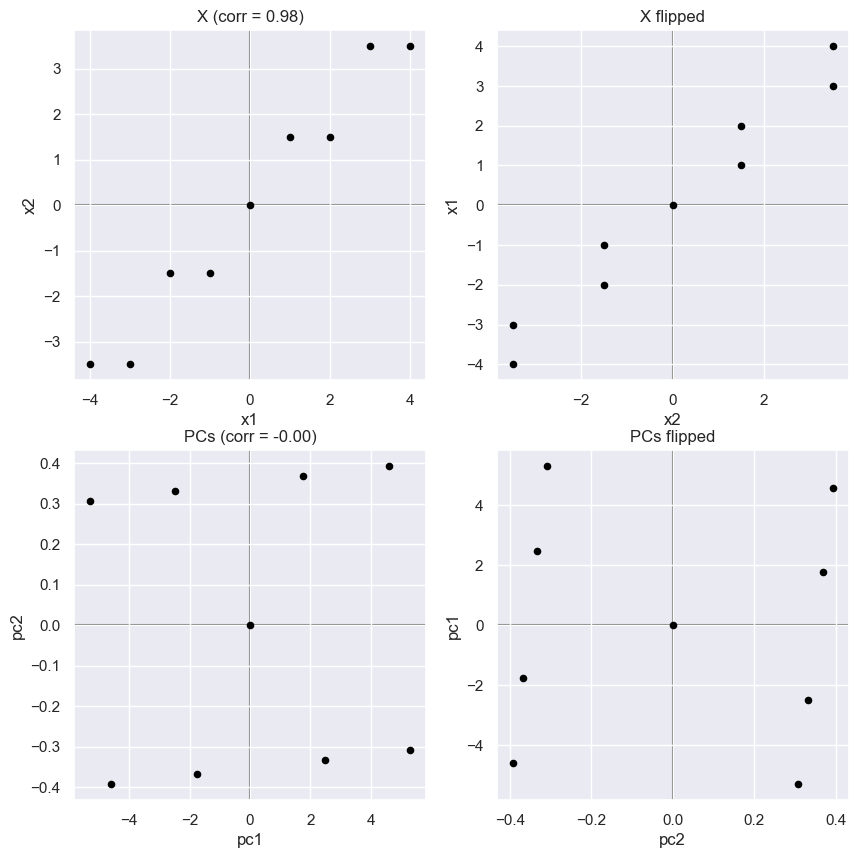

In [3]:
X_train = pd.DataFrame(
    {
        "x1": [-4  , -3  , -2  , -1  , 0, +1  , +2  , +3  , +4  ],
        "x2": [-3.5, -3.5, -1.5, -1.5, 0, +1.5, +1.5, +3.5, +3.5],
    }
)

pc_mults = _get_pc_mults(
    X=X_train,
    var_frac=None,
)
pcs_train = calc_pcs(
    X=X_train,
    mults=pc_mults,
)


_, axs = plt.subplots(
    nrows=2,
    ncols=2,
)
####
fsc.plot(
    X_train,
    kind="scatter",
    axvline_locs=[0],
    title=f"""X (corr = {X_train.corr().loc["x1", "x2"] :.2f})""",
    ax=axs[0, 0],
)
fsc.plot(
    X_train[["x2", "x1"]],
    kind="scatter",
    axvline_locs=[0],
    title=f"""X flipped""",
    ax=axs[0, 1],
)
##
fsc.plot(
    pcs_train,
    kind="scatter",
    axvline_locs=[0],
    title=f"""PCs (corr = {pcs_train.corr().loc["pc1", "pc2"] :.2f})""",
    ax=axs[1, 0],
)
fsc.plot(
    pcs_train[["pc2", "pc1"]],
    kind="scatter",
    axvline_locs=[0],
    title=f"""PCs flipped""",
    ax=axs[1, 1],
    figsize=(10, 10),
)
####
plt.show()

In [4]:
del axs, pcs_train, pc_mults, X_train

# DATA

In [5]:
N_QUARTERS: Final[int] = 4

N_TICKERS: Final[int] = 500
N_ASSETCLASSES: Final[int] = 4
N_COUNTRIES: Final[int] = 5
N_SECTORS: Final[int] = 5
# 5 tickers per sector
N_TICKERS_PER_SECTOR: Final[int] = int(
    N_TICKERS
    / N_ASSETCLASSES
    / N_COUNTRIES
    / N_SECTORS
)
assert N_TICKERS_PER_SECTOR == 5, N_TICKERS_PER_SECTOR

# # debug
# N_QUARTERS: Final[int] = 2
# N_TICKERS: Final[int] = 16
# N_ASSETCLASSES: Final[int] = 2
# N_COUNTRIES: Final[int] = 2
# N_SECTORS: Final[int] = 2
# # 2 tickers per sector
# assert N_TICKERS_PER_SECTOR == 2, N_TICKERS_PER_SECTOR

In [6]:
# index
ix__q = (
    sum(
        (
            [f"q{q}"] * N_TICKERS
            for q in range(1, N_QUARTERS+1)
        ),
        start=[],
    )
)
ix__ticker = (
    [
        f"ticker{t}"
        for t in range(1, N_TICKERS+1)
    ]
    * N_QUARTERS
)

ix = pd.MultiIndex.from_frame(
    pd.DataFrame(
        {
            "q": ix__q,
            "ticker": ix__ticker,
        }
    )
)
del ix__ticker, ix__q


ix

MultiIndex([('q1',   'ticker1'),
            ('q1',   'ticker2'),
            ('q1',   'ticker3'),
            ('q1',   'ticker4'),
            ('q1',   'ticker5'),
            ('q1',   'ticker6'),
            ('q1',   'ticker7'),
            ('q1',   'ticker8'),
            ('q1',   'ticker9'),
            ('q1',  'ticker10'),
            ...
            ('q4', 'ticker491'),
            ('q4', 'ticker492'),
            ('q4', 'ticker493'),
            ('q4', 'ticker494'),
            ('q4', 'ticker495'),
            ('q4', 'ticker496'),
            ('q4', 'ticker497'),
            ('q4', 'ticker498'),
            ('q4', 'ticker499'),
            ('q4', 'ticker500')],
           names=['q', 'ticker'], length=2000)

## X

In [7]:
# qualitative features
XNAMES_QUAL: Final[Sequence[str]] = [
    "ac",
    "ccy",
    "sector",
]

x__ac = (
    sum(
        (
            [f"_ac{a}"] * int(N_TICKERS/N_ASSETCLASSES)
            for a in range(1, N_ASSETCLASSES+1)
        ),
        start=[],
    )
    * N_QUARTERS
)
x__ccy = (
    sum(
        (
        
            [f"_ccy{s}"] * int(N_TICKERS/N_ASSETCLASSES/N_COUNTRIES)
            for s in range(1, N_COUNTRIES+1)
        ),
        start=[],
    )
    * N_ASSETCLASSES
    * N_QUARTERS
)
x__sector = (
    sum(
        (
        
            [f"_sector{s}"] * int(N_TICKERS/N_ASSETCLASSES/N_COUNTRIES/N_SECTORS)
            for s in range(1, N_SECTORS+1)
        ),
        start=[],
    )
    * N_COUNTRIES
    * N_ASSETCLASSES
    * N_QUARTERS
)

_dta_qual = pd.DataFrame(
    {
        "q": ix.map(lambda q_ticker: q_ticker[0]),
        "ac": x__ac,
        "ccy": x__ccy,
        "sector": x__sector,
    },
    index=ix,
)
del x__sector, x__ccy, x__ac
cohort = _dta_qual.sum(axis="columns").rename("cohort")


cohort

q   ticker   
q1  ticker1      q1_ac1_ccy1_sector1
    ticker2      q1_ac1_ccy1_sector1
    ticker3      q1_ac1_ccy1_sector1
    ticker4      q1_ac1_ccy1_sector1
    ticker5      q1_ac1_ccy1_sector1
                        ...         
q4  ticker496    q4_ac4_ccy5_sector5
    ticker497    q4_ac4_ccy5_sector5
    ticker498    q4_ac4_ccy5_sector5
    ticker499    q4_ac4_ccy5_sector5
    ticker500    q4_ac4_ccy5_sector5
Name: cohort, Length: 2000, dtype: object

In [8]:
# quantitative features
XNAMES_QUANT: Final[Sequence[str]] = [
    "v",
    "m",
    "c",
    "d",
]

_dta_quant = pd.DataFrame(
    {
        "v": [-8, -2,  0, +2, +8],
        "m": [+1,  0,  0,  0, -1],
        "c": [+1, -1, +1, -1, +1],
        "d": [-2, +1, +1, -2, -4],
    }
)
assert len(_dta_quant) == N_TICKERS_PER_SECTOR, len(dta_quant)
_dta_quant = pd.concat(
    [_dta_quant] * int(N_TICKERS / len(_dta_quant)) * N_QUARTERS,
    ignore_index=True,
).set_index(ix)

_dta_quant_train = _dta_quant.drop(index="q4")
_dta_quant_test = _dta_quant.loc[["q4"], :]

# dim-reduction
pc_mults_trained = _get_pc_mults(
    X=_dta_quant_train,
)


pc_mults_trained

,v,m,c,d
pc1,0.977586,-0.114372,0.003611,-0.176724


In [9]:
_pcs_train = calc_pcs(
    X=_dta_quant_train,
    mults=pc_mults_trained,
)

# rank-stdize
dta_quant_train = (
    _pcs_train
    .groupby(cohort)
    .rank()
)
subtracted = dta_quant_train.


dta_quant_train

pc1
q  ticker        
q1 ticker1    1.0
   ticker2    2.0
   ticker3    3.0
   ticker4    4.0
   ticker5    5.0
...           ...
q3 ticker496  1.0
   ticker497  2.0
   ticker498  3.0
   ticker499  4.0
   ticker500  5.0

[1500 rows x 1 columns]

In [10]:
_pcs_test = calc_pcs(
    X=_dta_quant_test,
    mults=pc_mults_trained,
)

# rank-stdize
dta_quant_test = (
    _pcs_test
    .groupby(cohort)
    .rank()
)


dta_quant_test

pc1
q  ticker        
q4 ticker1    1.0
   ticker2    2.0
   ticker3    3.0
   ticker4    4.0
   ticker5    5.0
...           ...
   ticker496  1.0
   ticker497  2.0
   ticker498  3.0
   ticker499  4.0
   ticker500  5.0

[500 rows x 1 columns]

## y

In [205]:
_y_train = np.sign(
    _dta_quant_train
    .sum(axis="columns")
)
# flip sign w.p. 0.10
is_flip = (
    np.random
    .default_rng(seed=42)
    .choice(
        a=[1   , -1  ],
        p=[0.90, 0.10],
        size=len(_y_train)
    )
)
y_train = _y_train * is_flip
del is_flip
y_train = (np.sign(y_train) > 0).astype(int)


y_train

q   ticker   
q1  ticker1      0
    ticker2      0
    ticker3      1
    ticker4      0
    ticker5      1
                ..
q3  ticker496    0
    ticker497    0
    ticker498    1
    ticker499    0
    ticker500    1
Length: 1500, dtype: int64

In [206]:
y_train.mean()

0.41333333333333333

In [207]:
_y_test = np.sign(
    _dta_quant_test
    .sum(axis="columns")
)
# flip sign w.p. 0.10
is_flip = (
    np.random
    .default_rng(seed=42)
    .choice(
        a=[1   , -1  ],
        p=[0.90, 0.10],
        size=len(_y_test)
    )
)
y_test = _y_test * is_flip
del is_flip
y_test = (np.sign(y_test) > 0).astype(int)


y_test

q   ticker   
q4  ticker1      0
    ticker2      0
    ticker3      1
    ticker4      0
    ticker5      1
                ..
    ticker496    0
    ticker497    0
    ticker498    1
    ticker499    0
    ticker500    1
Length: 500, dtype: int64

In [208]:
y_test.mean()

0.418

# MODEL

In [171]:
fitter = sklearn.linear_model.LogisticRegression()

In [212]:
fitted = fitter.fit(
    X=dta_quant_train,
    y=y_train,
)


fitted.coef_

array([[0.73778264]])

In [215]:
y_train_pred = pd.Series(
    fitted.predict_proba(
        X=dta_quant_train,
    )
    [:, 1],
    index=dta_quant_train.index,
)


y_train_pred

q   ticker   
q1  ticker1      0.128267
    ticker2      0.235307
    ticker3      0.391550
    ticker4      0.573704
    ticker5      0.737838
                   ...   
q3  ticker496    0.128267
    ticker497    0.235307
    ticker498    0.391550
    ticker499    0.573704
    ticker500    0.737838
Length: 1500, dtype: float64

In [216]:
y_train_pred.corr(
    y_train
)

0.4319768813169855

In [219]:
fitted.score(
    X=dta_quant_train,
    y=y_train,
)

0.5746666666666667

In [214]:
y_test_pred = pd.Series(
    fitted.predict_proba(
        X=dta_quant_test,
    )
    [:, 1],
    index=dta_quant_test.index,
)


y_test_pred

q   ticker   
q4  ticker1      0.128267
    ticker2      0.235307
    ticker3      0.391550
    ticker4      0.573704
    ticker5      0.737838
                   ...   
    ticker496    0.128267
    ticker497    0.235307
    ticker498    0.391550
    ticker499    0.573704
    ticker500    0.737838
Length: 500, dtype: float64

In [218]:
y_test_pred.corr(
    y_test
)

0.41784457934109953

In [220]:
fitted.score(
    X=dta_quant_test,
    y=y_test,
)

0.558

# SCORE

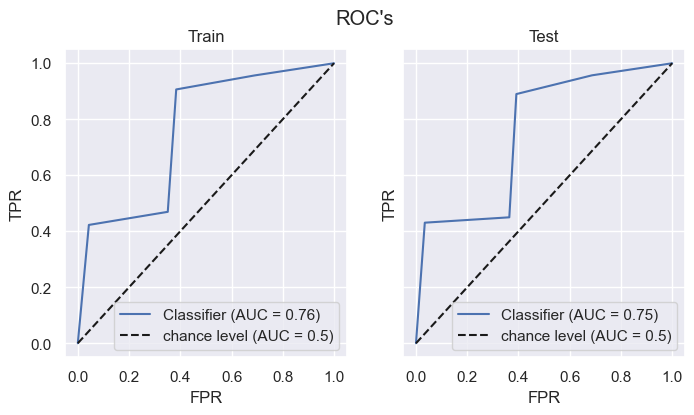

In [225]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)

ax = axs[0]
sklearn.metrics.RocCurveDisplay.from_predictions(
    y_true=y_train,
    y_pred=y_train_pred,
    ax=ax,
)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("Train")
ax.legend()

ax = axs[1]
sklearn.metrics.RocCurveDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_test_pred,
    ax=ax,
)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("Test")
ax.legend()

plt.suptitle("ROC's")
fig.set_size_inches(8, 4)
plt.show()